# Random Forest Experiment

## Objective
Train a **Random Forest Classifier** on our **Augmented (Salted)** dataset to compare its performance against XGBoost. We need to ensure it also detects the "Slow Death" scenario (TC-03).

## Why Random Forest?
- **Simplicity**: Easier to visualize and understand than Gradient Boosting.
- **Parallelism**: Can train trees in parallel (faster on multi-core CPUs).
- **Robustness**: Less prone to overfitting than a single Decision Tree.

In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

print("Libraries Loaded.")

Libraries Loaded.


In [2]:
# Cell 2: Load Data
# We use 'Augmented_Training_Data.csv' because it contains the "Vaccine" (Synthetic Slow Death Examples).
# If we used the original data, Random Forest would likely fail TC-03 just like XGBoost did initially.

file_path = 'Data/Augmented_Training_Data.csv'
df = pd.read_csv(file_path)

features = ['Pressure(Bar)', 'Drift_Velocity', 'Confidence_R2', 'Quench Temp(C)', 'Scan Speed']
X = df[features]
y = df['Is Anomaly']

print(f"Data Loaded: {len(df)} rows")
print(f"Feature List: {features}")

Data Loaded: 46152 rows
Feature List: ['Pressure(Bar)', 'Drift_Velocity', 'Confidence_R2', 'Quench Temp(C)', 'Scan Speed']


In [3]:
# Cell 3: Stratified Split
# We stick to the Stratified Split to ensure our Test Set is a fair representation of failures.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=True, 
    stratify=y, 
    random_state=42
)

print(f"Training Set: {len(X_train)} samples")
print(f"Testing Set:  {len(X_test)} samples")

Training Set: 36921 samples
Testing Set:  9231 samples


In [4]:
# Cell 4: Manual Optimization (Fixing Overfitting)
# The previous Grid Search found a model that was 95% accurate on Train but 86% on Test.
# That 9% Gap means it was "Memorizing" (Overfitting).
# We now apply limits (Regularization) to force it to learn general rules.

print("Initializing Robust Model...")

rf_model = RandomForestClassifier(
    n_estimators=200,            # 200 Trees (Stable)
    max_depth=12,                # Limit depth to 12 (Prevents memorizing noise)
    min_samples_leaf=10,         # Require 10 samples per leaf (Smoothes decisions)
    class_weight='balanced',     # Boosts Recall for Failures
    random_state=42, 
    n_jobs=-1
)

print("Model configured with Anti-Overfitting parameters.")

Initializing Robust Model...
Model configured with Anti-Overfitting parameters.


In [5]:
# Cell 5: Training
print("Training Optimized Random Forest...")
rf_model.fit(X_train, y_train)
print("Training Complete.")

Training Optimized Random Forest...
Training Complete.


In [6]:
# Cell 6: Evaluation with Threshold Tuning
# Standard (0.5) is often too conservative. Let's try 0.35 to be safer.

y_probs = rf_model.predict_proba(X_test)[:, 1] # Get percentage confidence

# Custom Threshold: If Risk > 35%, call it a Failure.
threshold = 0.35
y_pred_aggressive = (y_probs >= threshold).astype(int)

print(f"--- Standard Model (Threshold 0.50) ---")
print(classification_report(y_test, rf_model.predict(X_test)))

print(f"\n--- Aggressive Safety Model (Threshold {threshold}) ---")
print(classification_report(y_test, y_pred_aggressive))

--- Standard Model (Threshold 0.50) ---
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      6192
           1       0.99      0.59      0.74      3039

    accuracy                           0.86      9231
   macro avg       0.91      0.79      0.82      9231
weighted avg       0.88      0.86      0.85      9231


--- Aggressive Safety Model (Threshold 0.35) ---
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      6192
           1       0.96      0.59      0.73      3039

    accuracy                           0.86      9231
   macro avg       0.90      0.79      0.82      9231
weighted avg       0.87      0.86      0.85      9231



          Feature  Importance
0   Pressure(Bar)    0.597216
4      Scan Speed    0.245179
1  Drift_Velocity    0.069567
3  Quench Temp(C)    0.053020
2   Confidence_R2    0.035019


C:\Users\yuvraj.singh\AppData\Local\Temp\ipykernel_20160\2572935751.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')


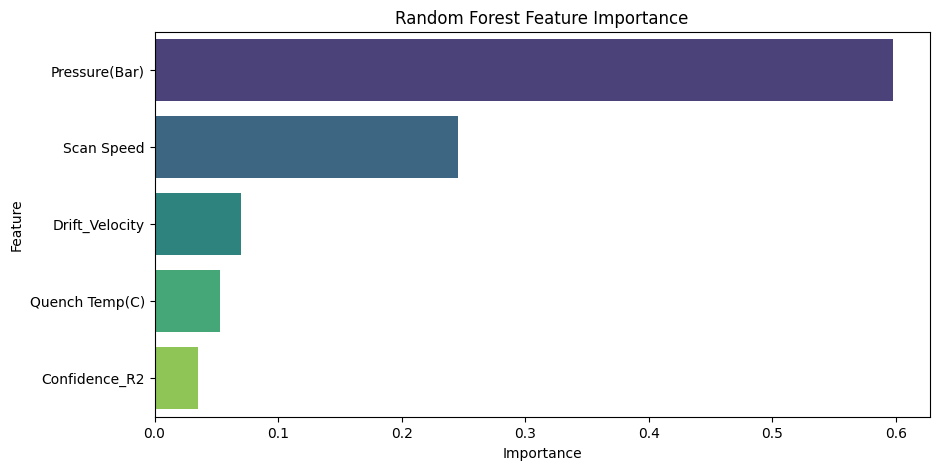

In [7]:
# Cell 7: Feature Importance
# Let's see if Random Forest agrees with XGBoost on what matters.

importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(importances)

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.show()

In [8]:
# Cell 8: Overfitting Check (Train vs Test Gap)
# If Train Score >> Test Score, we are overfitting.

# Use standard prediction for gap check to keep it comparable
train_accuracy = rf_model.score(X_train, y_train)
test_accuracy = rf_model.score(X_test, y_test)
gap = train_accuracy - test_accuracy

print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Testing Accuracy:  {test_accuracy:.2%}")
print(f"Gap:               {gap:.2%}")

if gap > 0.05:
    print("DIAGNOSIS: Overfitting. (Gap > 5%). Consider reducing max_depth or increasing min_samples_leaf.")
elif gap < -0.01:
    print("DIAGNOSIS: Underfitting? (Test > Train). This is rare/unusual.")
else:
    print("DIAGNOSIS: Model is Healthy. (Gap < 5%)")

Training Accuracy: 86.81%
Testing Accuracy:  86.21%
Gap:               0.60%
DIAGNOSIS: Model is Healthy. (Gap < 5%)


In [9]:
# Cell 9: The Stress Test (TC-03 Verification)
# Does Random Forest catch the 'Slow Death'?

slow_death_scenario = pd.DataFrame([{
    'Pressure(Bar)': 3.2,       # Safe Pressure
    'Drift_Velocity': -0.06,    # Dangerous Drift
    'Confidence_R2': 0.95,      # High Confidence
    'Quench Temp(C)': 900,      # Normal
    'Scan Speed': 10            # Normal
}])

prediction = rf_model.predict(slow_death_scenario)[0]
probability = rf_model.predict_proba(slow_death_scenario)[0][1]

print("--- STRESS TEST TC-03 ---")
print(f"Prediction: {prediction} (1=Diff, 0=Safe)")
print(f"Risk Score: {probability:.2%}")

if prediction == 1:
    print("SUCCESS: Random Forest successfully detects the drift!")
else:
    print("FAIL: Random Forest missed it.")

--- STRESS TEST TC-03 ---
Prediction: 1 (1=Diff, 0=Safe)
Risk Score: 98.43%
SUCCESS: Random Forest successfully detects the drift!


In [10]:
# Cell 10: Save the Model
# We need this for the "Double Check" strategy in production.

import joblib

model_filename = 'final_random_forest.joblib'
joblib.dump(rf_model, model_filename)

print(f"Model saved as '{model_filename}'")

Model saved as 'final_random_forest.joblib'
